In [1]:
# DEAP
from deap import gp, base, tools, creator, algorithms

# Data processing and plotting
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Requirements for the algorithm
from operator import attrgetter
from functools import partial

# Standard python imports
import random, pickle, math, re, os
import numpy as np

# Magic for inline plots
%matplotlib inline



In [2]:
# Dataset parameters
DATASET = "MNIST" # choose from {"MNIST", "Fashion-MNIST"} 
N_CLASSES_TO_USE = 10 # at most 10

# Individual tree parameters
MAX_ARITY = 10
MIN_INITIAL_HEIGHT = 3
MAX_INITIAL_HEIGHT = 5

HEIGHT_CAPPED = True
MAX_AVG_HEIGHT = 20

# Fitness parameters
SAMPLE_SIZE = 100

# Evolution parameters
N_GENERATIONS = 1000
POPULATION_SIZE = 100

TOURNAMENT_SIZE = 32
SIZE_TOURNAMENT = True
P_SMALLER_WINS = 0.65

P_CROSSOVER = 1.0
P_CROSSOVER_PER_TREE = 1.0

P_MUTATION = 0.3
P_MUTATION_PER_TREE = 0.2
MIN_MUTATION_HEIGHT = 1
MAX_MUTATION_HEIGHT = 3

# Filename parameters
RESULTS_FILENAME = f"DEAP-{DATASET}-results.pkl"

# Set the correct data filename
filename = f"{DATASET}-{N_CLASSES_TO_USE}.pkl"

# If the data has not yet been preprocessed in the specified way, do so now
if not os.path.exists(os.path.join("data", filename)):
    print("Preprocessed dataset does not exist yet, creating now.")
    os.system(f"python Preprocessing.py -d {DATASET} -c {N_CLASSES_TO_USE}")

# Load the preprocessed data
with open(os.path.join("data", filename), "rb") as f:
    (X_train, Y_train), (X_test, Y_test) = pickle.load(f)

## Necessary Code for Loading Results

In [3]:
# Create set of functions and terminals, with one terminal for each pixel
pset = gp.PrimitiveSet("main", X_train.shape[1])

In [4]:
# Define operators (with a variable number of inputs)
def linear(*args):
    return sum(args)

def step(*args):
    return float(sum(args) > 0)

def sine(*args):
    return np.sin(np.pi*sum(args))

def gaussian(*args):
    return exp(-np.multiply(sum(args), sum(args))/2.0)

def tanh(*args):
    return np.tanh(sum(args))

def sigmoid(*args):
    return (np.tanh(sum(args)/2.0) + 1.0)/2.0

def inverse(*args):
    return -sum(args)

def absolute(*args):
    return abs(sum(args))

def relu(*args):
    return np.maximum(0.0, sum(args))

def cosine(*args):
    return np.cos(np.pi*sum(args))

# Add operators to the set (using a "hacky" solution to allow variable arities)
for arity in range(1, MAX_ARITY+1):
    pset.addPrimitive(linear, arity)
    pset.addPrimitive(step, arity)
    pset.addPrimitive(sine, arity)
    pset.addPrimitive(gaussian, arity)
    pset.addPrimitive(tanh, arity)
    pset.addPrimitive(sigmoid, arity)
    pset.addPrimitive(inverse, arity)
    pset.addPrimitive(absolute, arity)
    pset.addPrimitive(relu, arity)
    pset.addPrimitive(cosine, arity)

In [5]:
# Intialize the toolbox which will contain all sorts of functions for the genetic programming process
toolbox = base.Toolbox()

# Define how to create a random expression/tree (using half-and-half intialization)
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=MIN_INITIAL_HEIGHT, max_=MAX_INITIAL_HEIGHT)

# Define classes for fitness, trees and individuals (using DEAP's creator module)
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Tree", gp.PrimitiveTree)
creator.create("Individual", list, fitness=creator.FitnessMin) # An individual is a list of single-output trees

# Define how to initialize a tree, individual or population
toolbox.register("tree", tools.initIterate, creator.Tree, toolbox.expr)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.tree, N_CLASSES_TO_USE)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Define how to compile a single tree and an individual
toolbox.register("compile_tree", gp.compile, pset=pset)

# Define how to compile an individual (list of trees)
def compile_individual(individual):
    # Compile all trees in the individual
    funcs = [toolbox.compile_tree(t) for t in individual]
    
    # Create the function, which applies softmax over the outputs of the created lambda functions
    def func(args):
        def _softmax(x):
            return exp(x)/np.sum(exp(x), axis=0)
        return _softmax([f(*args) for f in funcs])
    
    # Return the created function
    return func

# Add compile_individual to toolbox
toolbox.register("compile_individual", compile_individual)

# Define fitness function   
def fitness(individual, sample_size):
    # Compile the individual to obtain the corresponding function
    func = toolbox.compile_individual(individual)
    
    # Define how to compute cross-entropy
    def _cross_entropy(pred, label):
        return -np.log(pred[label])
    
    # Create a list of samples to test, ensuring an equal number of samples from each class
    sample_indices = []
    samples_per_class = int(sample_size/N_CLASSES_TO_USE)
    for c in range(N_CLASSES_TO_USE):
        c_indices = np.where(Y_train == c)[0]
        assert len(c_indices) >= samples_per_class, \
            f"Class {c} has too few elements to reach the desired number of evaluation samples"
        sample_indices.extend(np.random.permutation(c_indices)[:samples_per_class])
    
    # Compute cross-entropy loss for each of the samples
    losses = [_cross_entropy(func(X_train[i]), Y_train[i]) for i in sample_indices]
    
    # Return the average cross-entropy loss
    return (np.average(losses),)

# Add the fitness function to the toolbox
toolbox.register("evaluate", fitness, sample_size=SAMPLE_SIZE)

## Load Results DEAP

In [6]:
RESULTS_FILENAME = f"DEAP-{DATASET}-results.pkl"

# Load results
with open(RESULTS_FILENAME, "rb") as f:
    pop, log, hof = pickle.load(f)

# Extract generation IDs, minimum fitnesses and average total heights per generation
gen = log.select("gen")
fitness_best_deap = log.chapters["fitness"].select("min") 
fitness_avg_deap = log.chapters["fitness"].select("avg")


## Load Results NEAT

In [7]:
history = np.genfromtxt('NEAT-results/fitness_history.csv', delimiter='')
fitness_best_neat = history[:,0]
fitness_avg_neat = history[:,1]

## Load Results DEAP-NEAT

In [8]:

N_CLASSES_TO_USE = 10 # at most 10

# Individual trees
P_INITIAL_CONNECTION = 0.05

# Fitness
SAMPLE_SIZE = 200
WEIGHTS_TO_TEST = [-2, -1, 1, 2] # -0.5 and 0.5 are not used due to long runtime

# Parent selection
TOURNAMENT_SIZE = 32

# Mutation (probabilities should sum to 1)
P_MUTATE_ACTIVATION = 0.5
P_ADD_NODE = 0.25
P_ADD_CONNECTION = 0.2
P_ENABLE_CONNECTION = 0.05

# Evolution
POPULATION_SIZE = 250
N_GENERATIONS = 1000
CULL_RATIO = 0.2
ELITE_RATIO = 0.2


# Generic Node class
class Node:
    def __init__(self, name):
        # Each node has a name and a list of parents
        self.name = name
        self.parents = []
    
    def __str__(self):
        raise NotImplementedError("String function is only implemented for subclasses")

# Class for terminal nodes (inputs)
class TerminalNode(Node):
    def __init__(self, name):
        super().__init__(name)

    def __str__(self):
        # Terminal nodes are simply formatted as their name (e.g. "ARG42")
        return self.name

# Class for non-terminal nodes (hidden + outputs)
class NonterminalNode(Node):
    def __init__(self, name):
        # Non-terminal nodes also have lists of children and disabled children
        super().__init__(name)
        self.children = []
        self.disabled = []

    def __str__(self):
        # Non-terminal nodes are formatted as "name(child1, child2, ...)"
        return f"{self.name}(w, {', '.join([str(child) for child in self.children])})"

    # Class for multi-output trees
class MultiClassTree:
    def __init__(self, n_inputs, n_outputs, p_initial_connection):
        # Initialize lists of input, output and internal nodes
        self.inputs = [TerminalNode(argument_names[i]) for i in range(n_inputs)]
        self.outputs = [NonterminalNode("linear") for _ in range(n_outputs)]
        self.hidden = []
        self.born = -1
        
        # Add initial connections
        self.n_connections = 0
        for output in self.outputs:
            # With a chance of P_INITIAL_CONNECTION, the connection is enabled, otherwhise it is disabled
            for child in self.inputs:
                if random.random() < P_INITIAL_CONNECTION:
                    output.children.append(child)
                else:
                    output.disabled.append(child)
                child.parents.append(output)
                
            # If an output has no enabled children, one of the children is enabled to make the tree valid
            if not output.children:
                child = random.choice(self.inputs)
                output.disabled.remove(child)
                output.children.append(child)
            
            # Update the number of enabled connections in the tree
            self.n_connections += len(output.children)

    def __str__(self):
        # Printing the tree only prints the number of hidden nodes and enabled connections
        return f"MultiClassTree with {len(self.hidden)} hidden nodes and {self.n_connections} connections"\
                + (f", born in generation {self.born}" if self.born >= 0 else "")
    
    def get_strings(self):
         # (Recursively) parsing output function strings, to parse the tree for evaluation
        try:
            return [str(output) for output in self.outputs]
        except RecursionError:
            print("Maximum recursion depth reached")
            return None
# Intialize the toolbox which will contain all sorts of functions for the genetic programming process
toolbox = base.Toolbox()

# Define classes for fitness and individuals (using DEAP's creator module)
creator.create("Fitness", base.Fitness, weights=(-1.0, -1.0))
creator.create("Individual", MultiClassTree, fitness=creator.Fitness, rank=-1) # An individual is a multi-class tree

# Define how to initialize an individual or population
toolbox.register("individual", creator.Individual, X_train.shape[1], N_CLASSES_TO_USE, P_INITIAL_CONNECTION)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Compiling a tree into a function
def compile_multiclasstree(tree):
    # Parse trees to strings for all outputs
    strings = tree.get_strings()
    
    # Convert the string to lambda functions using eval() and the proper function context
    funcs = [eval(f"lambda w, {', '.join(argument_names)}: {string}", function_context, {}) for string in strings]
    
    # Create the function, which applies softmax over the outputs of the created lambda functions
    def func(w, args):
        def _softmax(x):
            return exp(x)/np.sum(exp(x), axis=0)
        return _softmax([f(w, *args) for f in funcs])
    
    # Return the created function
    return func

# Add the compile function to toolbox
toolbox.register("compile", compile_multiclasstree)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [9]:
RESULTS_FILENAME = f"DEAPWANN-{DATASET}-results.pkl"

# Load results
with open(RESULTS_FILENAME, "rb") as f:
    pop, log, hof = pickle.load(f)

# Extract generation IDs, minimum fitnesses and average total heights per generation
gen = log.select("gen")
fitness_best_deapneat = log.chapters["avg_fitness"].select("min") 
fitness_avg_deapneat = log.chapters["avg_fitness"].select("avg")

## Load Results WANN

In [13]:
stats = np.loadtxt('WANN/log/mnist256_final_final_stats.out', delimiter=',') 
runTime = np.loadtxt('WANN/log/sample_runTime.out', delimiter=',') 

In [15]:
fitness_best_wann = stats[:,2]
fitness_avg_wann = stats[:,7]

## Plot Fitness over Time

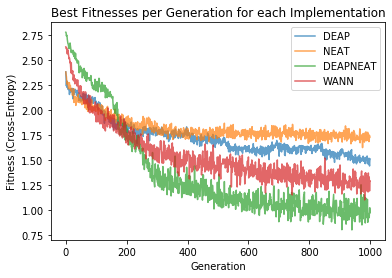

In [17]:
plt.plot(fitness_best_deap, label = 'DEAP', alpha=0.7)
plt.plot(abs(fitness_best_neat), label = 'NEAT', alpha=0.7)
plt.plot(fitness_best_deapneat, label = 'DEAPNEAT',alpha=0.7 )
plt.plot(abs(fitness_best_wann), label = 'WANN', alpha=0.7)

plt.title("Best Fitnesses per Generation for each Implementation")
plt.xlabel('Generation')
plt.ylabel('Fitness (Cross-Entropy)')
plt.legend()
plt.savefig('best_fitness_{}.png'.format(DATASET))
plt.show()

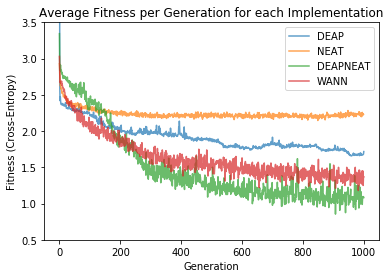

In [16]:
plt.plot(fitness_avg_deap, label = 'DEAP', alpha=0.7)
plt.plot(abs(fitness_avg_neat), label = 'NEAT', alpha=0.7)
plt.plot(fitness_avg_deapneat, label = 'DEAPNEAT',alpha=0.7 ) 
plt.plot(abs(fitness_avg_wann), label = 'WANN', alpha=0.7)
plt.ylim(0.5, 3.5)
plt.title("Average Fitness per Generation for each Implementation")
plt.xlabel('Generation')
plt.ylabel('Fitness (Cross-Entropy)')
plt.legend()
plt.savefig('avg_fitness_{}.png'.format(DATASET))
plt.show()